In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools
import pickle

In [2]:
training_data=pickle.load(open("data/unshuffled_data.pickle","rb"))
no_writers=55
no_signatures=24

In [3]:
#seperating signatures by writers
def seperate_writers(data,no_signatures,no_writers):
    chunks=[data[i:i+no_signatures] for i in range(0, len(data), no_signatures)]
    writer=[]
    for i in range(0,no_writers):
            writer.append(chunks[i]+chunks[i+no_writers])
    return writer

new_data=seperate_writers(training_data,no_signatures,no_writers)

In [4]:
#finding all combinations of pairs for image matching
def pair_combination(n):
    combinations=[]
    for i in itertools.combinations(range(0,n), 2):
        combinations.append(i)
        
    return combinations

pairings=pair_combination(48)

In [5]:
def mean_squared_error(data,no_writer,combination):
    MSE=[[] for i in range(0,no_writer)]
    for i in range(0,no_writer):
        for j in range(0,len(combination)):
            MSE[i].append(np.square(np.subtract(data[i][combination[j][0]][0], data[i][combination[j][1]][0])).mean())
    return MSE

MSE_data=mean_squared_error(new_data,no_writers,pairings)

In [6]:
def threshold_range(data):
    mx=[]
    mn=[]
    for i in range(0,len(data)):
        mx.append(max(data[i]))
        mn.append(min(data[i]))
    return np.linspace(min(mn),max(mx),100)

threshold=threshold_range(MSE_data)

In [7]:
def model_evaluation(data,threshold,no_writer,pairings,mse):
    tpr=[]
    fpr=[]
    accuracy=[]
    maximum=[]
    for x in threshold:
        tp=0
        fp=0
        tn=0
        fn=0
        for i in range(0,no_writer):
            for j in range(0,len(pairings)):
                if mse[i][j]<=x:
                        #matches
                    if data[i][pairings[j][0]][1] == data[i][pairings[j][1]][1]:
                        tp+=1
                    else:
                        fp+=1
                else:
                    if not(data[i][pairings[j][0]][1] == data[i][pairings[j][1]][1]):
                        tn+=1
                    else:
                        fn+=1
        thr_accuracy=(tp+tn)/(tp+tn+fp+fn)
        thr_tpr=tp/(tp+fn)
        thr_fpr=fp/(fp+tn)
        
        accuracy.append(thr_accuracy)
        tpr.append(thr_tpr)
        fpr.append(thr_fpr)   
        
        current_max=max(accuracy)
        if thr_accuracy==current_max:
            maximum=[x,thr_accuracy,thr_fpr,thr_tpr]
            
    return [fpr,tpr,accuracy,maximum]

fpr,tpr,accuracy,optimum=model_evaluation(new_data,threshold,no_writers,pairings,MSE_data)

In [8]:
opt_thresh,opt_acc,opt_fpr,opt_tpr=optimum

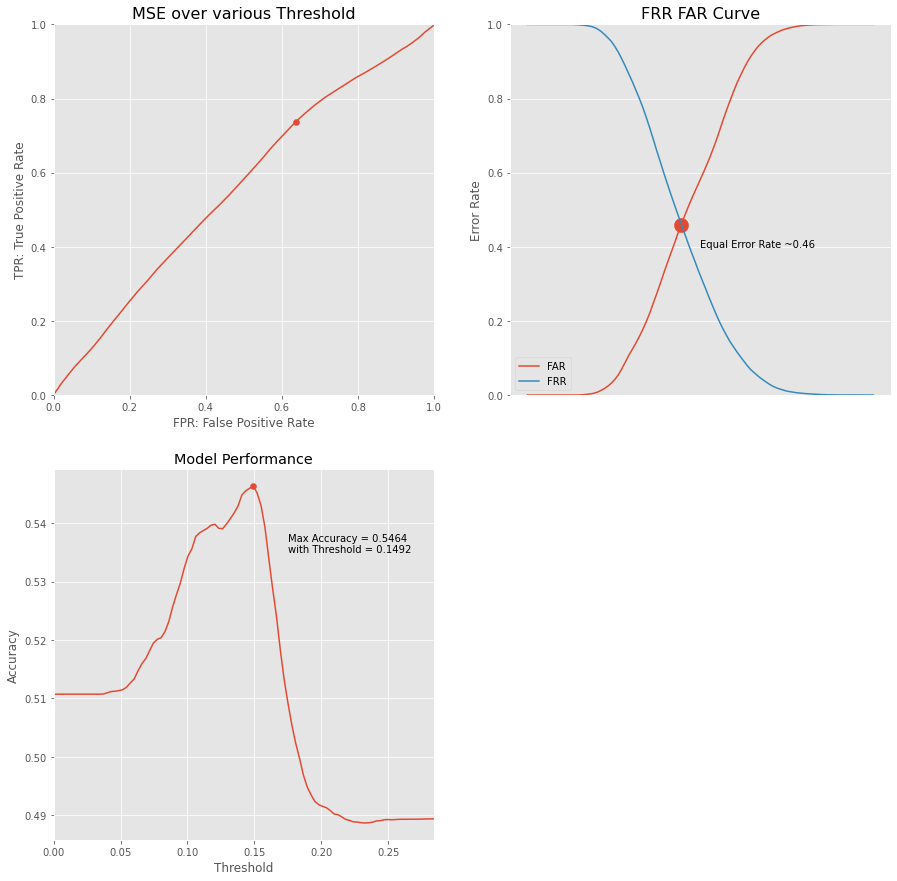

In [9]:
plt.style.use('ggplot')
figure, axis = plt.subplots(2,2,figsize=(15,15))

axis[0,0].set_title("MSE over various Threshold",fontsize=16)
axis[0,0].plot(fpr,tpr)
axis[0,0].scatter(opt_fpr,opt_tpr)
axis[0,0].set_xlim( 0, 1 )
axis[0,0].set_ylim( 0, 1 )
axis[0,0].set_xlabel("FPR: False Positive Rate")
axis[0,0].set_ylabel("TPR: True Positive Rate")

far,frr=np.array(fpr),1-np.array(tpr)
xval=np.linspace(0,1,num=len(far))
err=np.argwhere(np.diff(np.sign(far - frr))).flatten()
axis[0,1].set_title("FRR FAR Curve",fontsize=16)
axis[0,1].scatter(xval[err],far[err],s=200)
axis[0,1].text(0.5,0.4,"Equal Error Rate ~" +str(round(far[err][0],3)),fontsize = 10)
axis[0,1].plot(xval,far,label ='FAR')
axis[0,1].plot(xval,frr,label ='FRR')
axis[0,1].legend(loc ="lower left")
axis[0,1].set_ylabel('Error Rate')
axis[0,1].set_ylim(0, 1)
axis[0,1].axes.get_xaxis().set_visible(False)

axis[1,0].plot(threshold,accuracy)
axis[1,0].set_title("Model Performance")
axis[1,0].scatter(opt_thresh,opt_acc)
axis[1,0].set_xlim( min(threshold), max(threshold) )
axis[1,0].set_xlabel("Threshold")
axis[1,0].set_ylabel("Accuracy")
axis[1,0].text(0.175, 0.535, 'Max Accuracy = '+str(round(opt_acc,4)) + "\n"+
         "with Threshold = " +str(round(opt_thresh,4)), fontsize = 10)

plt.delaxes(axis[1,1])
plt.show()